# Ethnicity and ONS Covid Deaths

In [1]:
import sys
sys.path.insert(0, '../src/data')
import pandas as pd
import geopandas as gpd
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
import bame_datastore
bame_datastore.lib

Found local clean copy of Local_Authority_Districts__December_2009__Boundaries
Found local clean copy of fbook_covid_cases
Found local clean copy of BAME_report_cases
Found local clean copy of BAME_report_deaths
Found local clean copy of bame_excess_deaths
Found local clean copy of ons_deaths
Found local clean copy of ethnicity_2011
Found local clean copy of furlough_data
Found local clean copy of key_workers
Found local clean copy of deprivation_data
Found local clean copy of population_est_data


{'mortality': ['fbook_covid_data',
  'bame_rpt_deaths',
  'bame_rpt_excess_deaths',
  'ons_deaths'],
 'explanatory': ['ethnicity_data',
  'bame_rpt_cases',
  'furlough_data',
  'key_workers',
  'deprivation',
  'pop_est'],
 'other': ['lad_geog']}

In [3]:
#importing and cleaning our main dataset
ons_deaths_df = bame_datastore.ons_deaths.df # import ons mortality data
ethnicity_df = bame_datastore.ethnicity_data.df # import 2011 census data
ethnicity_list = ethnicity_df.columns[2:]
df = ons_deaths_df.join(ethnicity_df) # join by local authority

pop_df = bame_datastore.pop_est.df.copy() # import 2020 population estimates
df = df.join(pop_df.drop(columns = pop_df.columns[3:])) 
df.rename(columns={"All ages": "total_pop"}, inplace=True)
df["covid_deaths_pop"] = df["deaths_covid"]/df["total_pop"] # normalise deaths by population

df = df.drop(columns = ["Geography_code", "Denominator", "Code", "Geography1"])
df = df.dropna()

In [4]:
df.sort_values(by=['covid_deaths_pop'], ascending=False)

,deaths_all,deaths_covid,Arab,Asian,Asian Other,Bangladeshi,Black,Black African,Black Caribbean,Black Other,...,Other,Other ethnic group,Pakistani,White,White British,White Gypsy or Irish Traveller,White Irish,White Other,total_pop,covid_deaths_pop
Area Name,,,,,,,,,,,,,,,,,,,,,
Hertsmere,715,177,0.20,7.39,2.07,0.23,3.93,2.99,0.56,0.38,...,1.03,0.83,0.45,85.04,75.73,0.15,2.13,7.03,104919.0,0.001687
Harrow,1242,397,1.55,42.59,11.27,0.58,8.24,3.57,2.85,1.83,...,2.95,1.40,3.26,42.25,30.88,0.08,3.07,8.22,251160.0,0.001581
Brent,1411,484,3.67,34.06,9.19,0.56,18.84,7.84,7.62,3.38,...,5.77,2.09,4.62,36.27,17.96,0.10,3.96,14.25,329771.0,0.001468
Middlesbrough,1003,204,0.69,7.78,0.96,0.18,1.25,1.06,0.07,0.12,...,1.08,0.39,4.92,88.18,86.05,0.06,0.41,1.65,140980.0,0.001447
South Lakeland,887,148,0.03,0.76,0.23,0.05,0.18,0.10,0.06,0.01,...,0.09,0.06,0.04,98.36,95.59,0.03,0.34,2.39,105088.0,0.001408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Norwich,676,22,0.49,4.41,1.27,0.41,1.62,1.30,0.21,0.11,...,0.84,0.35,0.19,90.84,84.70,0.10,0.66,5.39,140573.0,0.000157
South Hams,488,12,0.08,0.55,0.20,0.08,0.15,0.09,0.04,0.01,...,0.15,0.06,0.01,98.37,95.84,0.05,0.45,2.03,87004.0,0.000138
Hastings,539,9,0.18,2.36,1.02,0.31,1.18,0.71,0.34,0.14,...,0.54,0.36,0.09,93.77,89.33,0.17,0.78,3.50,92661.0,0.000097


In [5]:
def reg_plot(df, cov_death_col):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in ethnicity_list: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    ax.set_title(f'Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}.png")

## Covid Deaths 
**Not** normalising for population


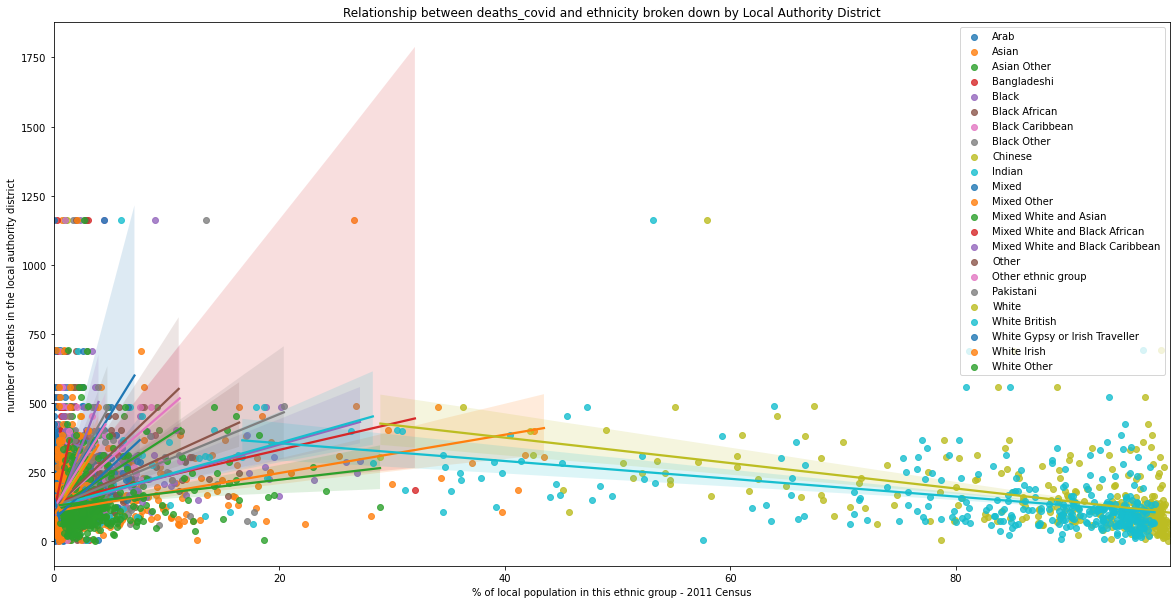

In [6]:
reg_plot(df, "deaths_covid")

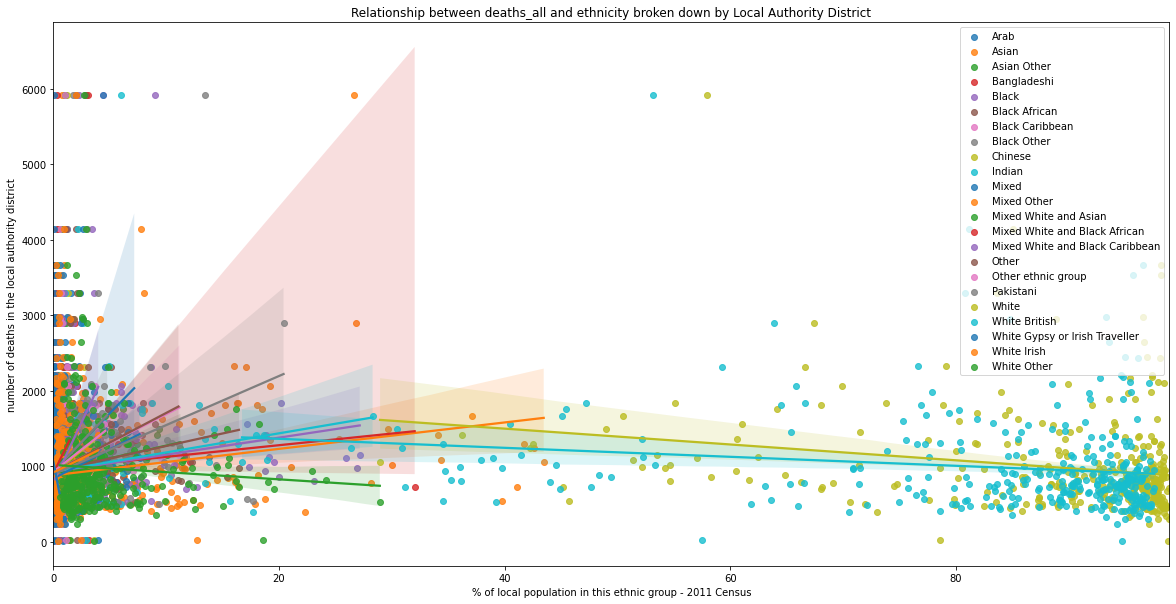

In [7]:
reg_plot(df, "deaths_all")

## Covid Deaths Normalising for Population
Using population estimated for [mid April 2020](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland)



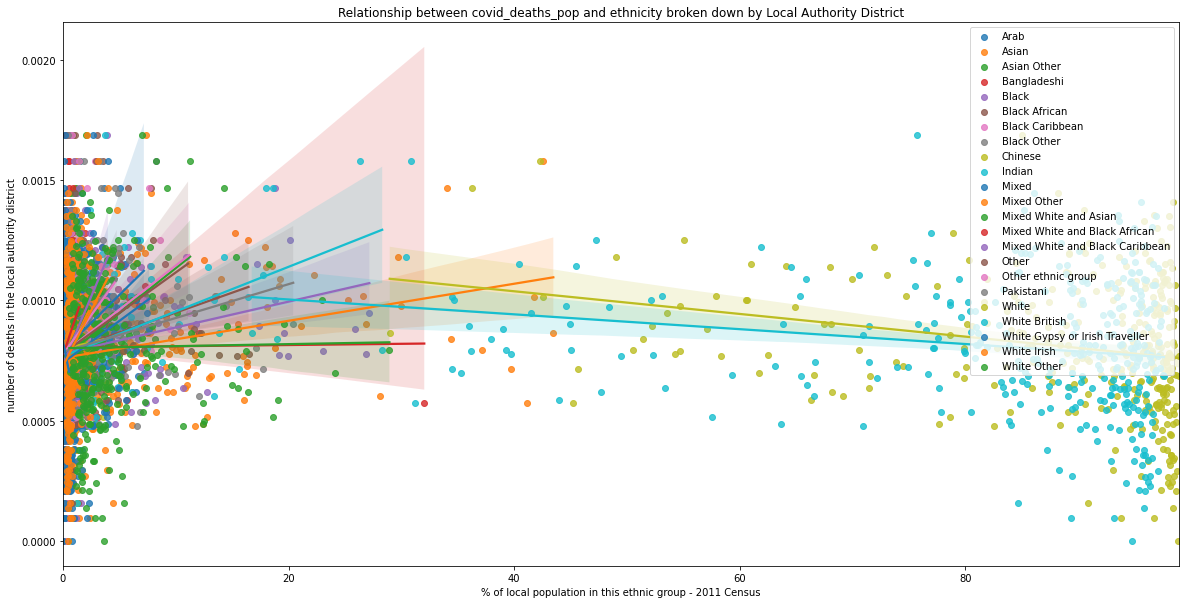

In [8]:
reg_plot(df, "covid_deaths_pop")

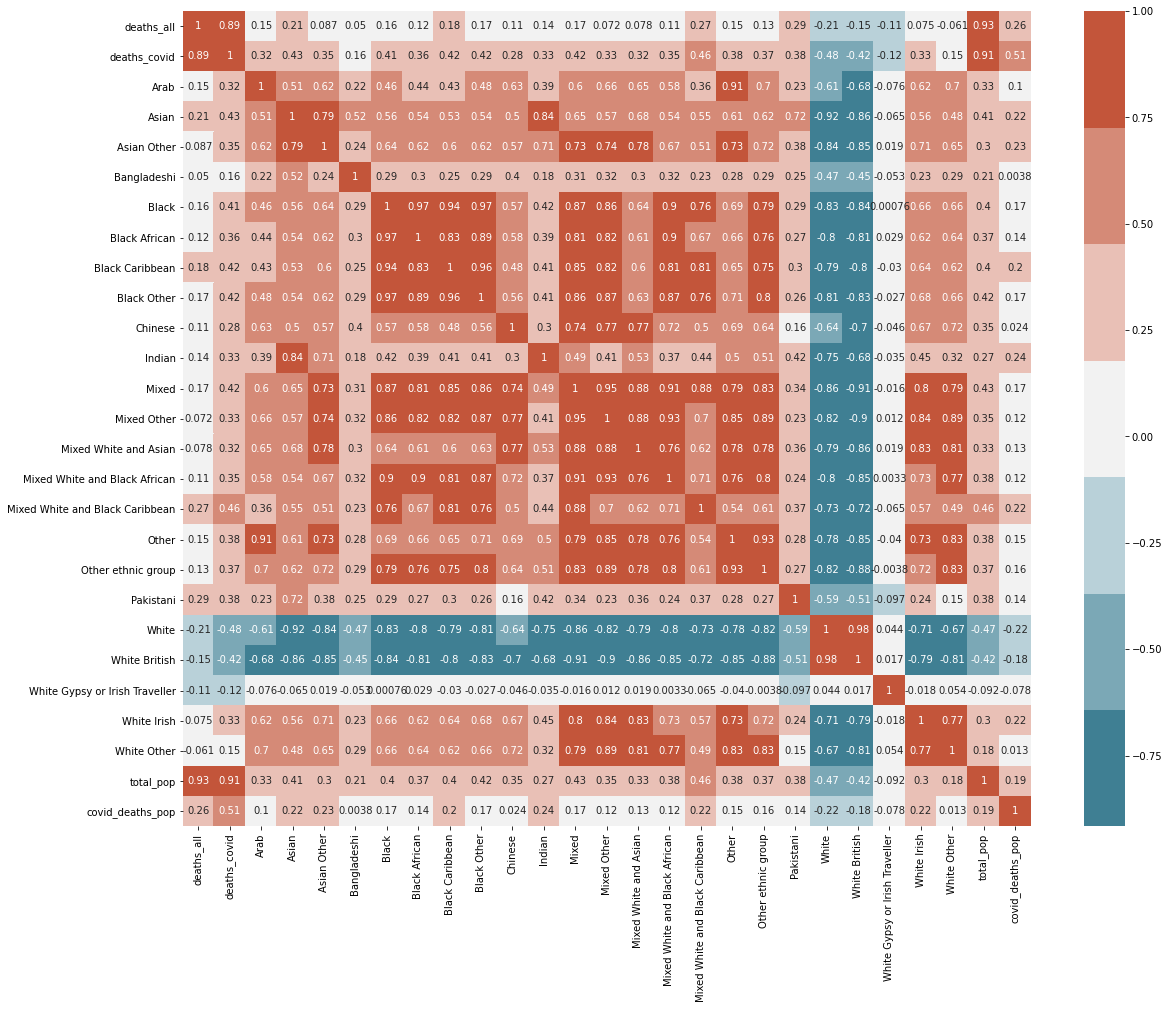

In [9]:
#correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat.png")

# Grouping Ethnicities
Grouping ethnicities based on the [5 broad ethnic groups](https://www.ethnicity-facts-figures.service.gov.uk/ethnic-groups) used by the goverment. However in doing so we are already losing the heterogeneity wthin these broad categories and may be missing the differing impacts within them.  

In [16]:
df_grouped = df.copy() # target data
df_grouped = df_grouped.drop(columns = ethnicity_list)
# sum groups to get total share
df_grouped["White"] = df[['White', 'White British','White Gypsy or Irish Traveller', 'White Irish', 'White Other']].sum(axis=1)
df_grouped["Mixed"] = df[['Mixed White and Black Caribbean','Mixed White and Asian',
                          'Mixed White and Black African', 'Mixed', 'Mixed Other', ]].sum(axis=1)
df_grouped["Black_African_Caribbean"] = df[['Black', 'Black African', 'Black Caribbean', 'Black Other']].sum(axis=1)
df_grouped["Asian"] = df[['Asian', 'Asian Other', 'Bangladeshi','Chinese','Indian', 'Pakistani', ]].sum(axis=1)
df_grouped["Other"] = df[[ 'Arab','Other', 'Other ethnic group', ]].sum(axis=1)

In [17]:
df_grouped.columns[4:]

Index(['White', 'Mixed', 'Black_African_Caribbean', 'Asian', 'Other'], dtype='object')

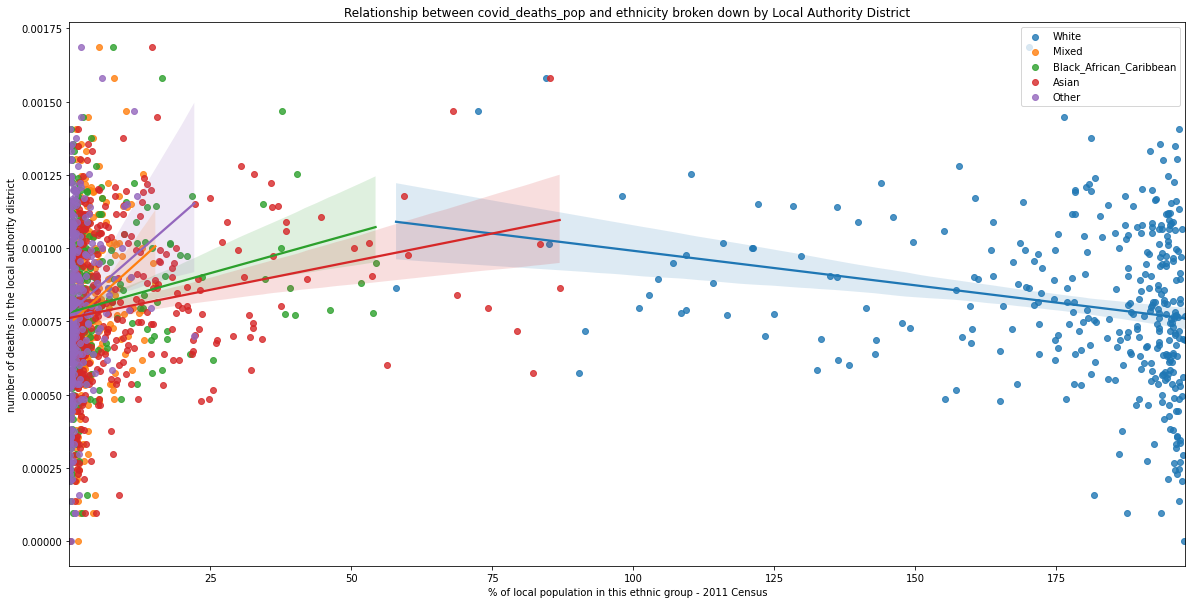

In [18]:
def reg_plot_alt(df, cov_death_col):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in df_grouped.columns[4:]: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    ax.set_title(f'Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}grouped.png")

reg_plot_alt(df_grouped, "covid_deaths_pop")


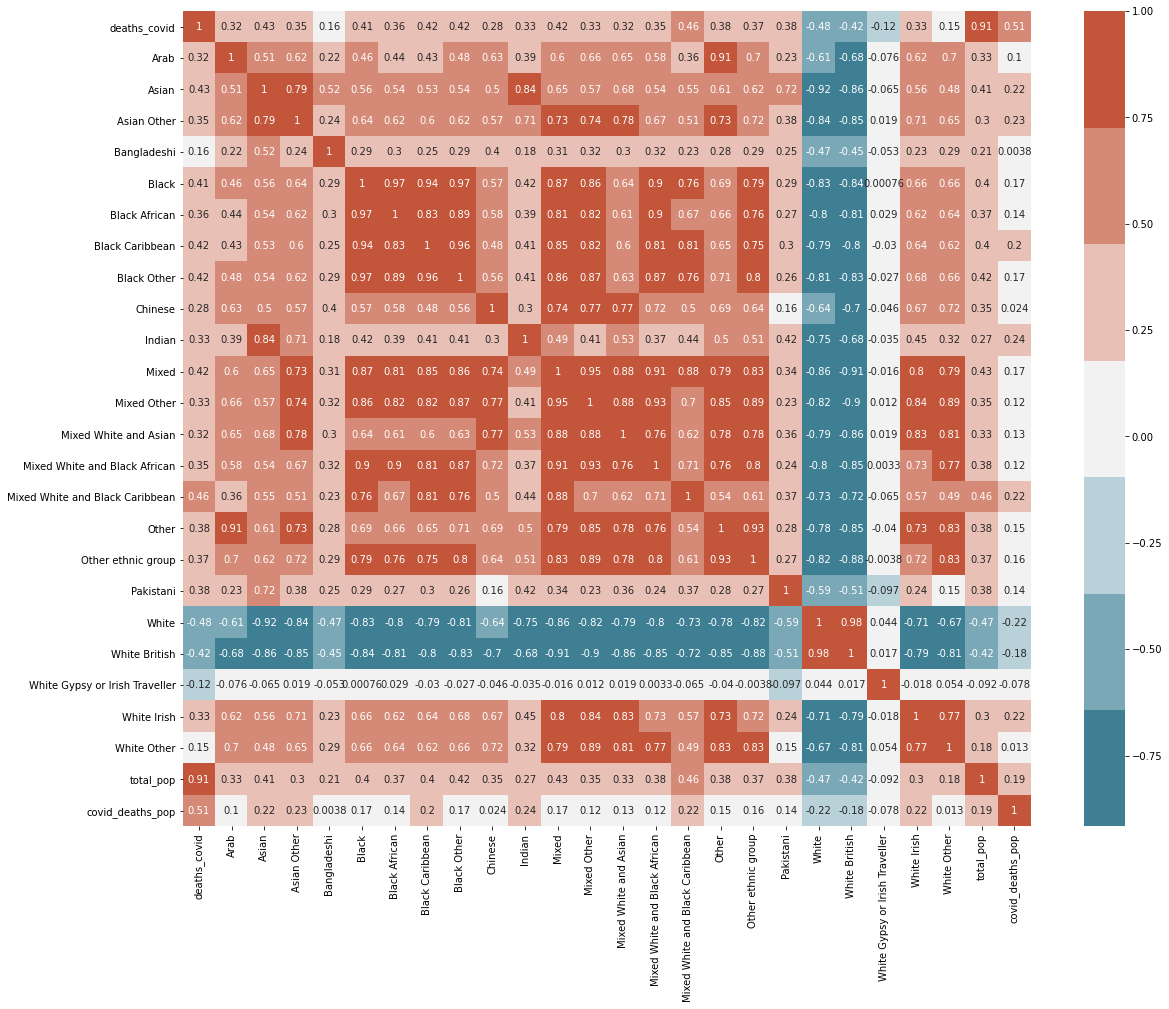

In [19]:
#correlation matrix of relevant variables
df_cor = df.drop(columns=["deaths_all"])
plt.figure(figsize=(19, 15))
corrMatrix = df_cor.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat_grouped.png")


## Deprivation and Furlough

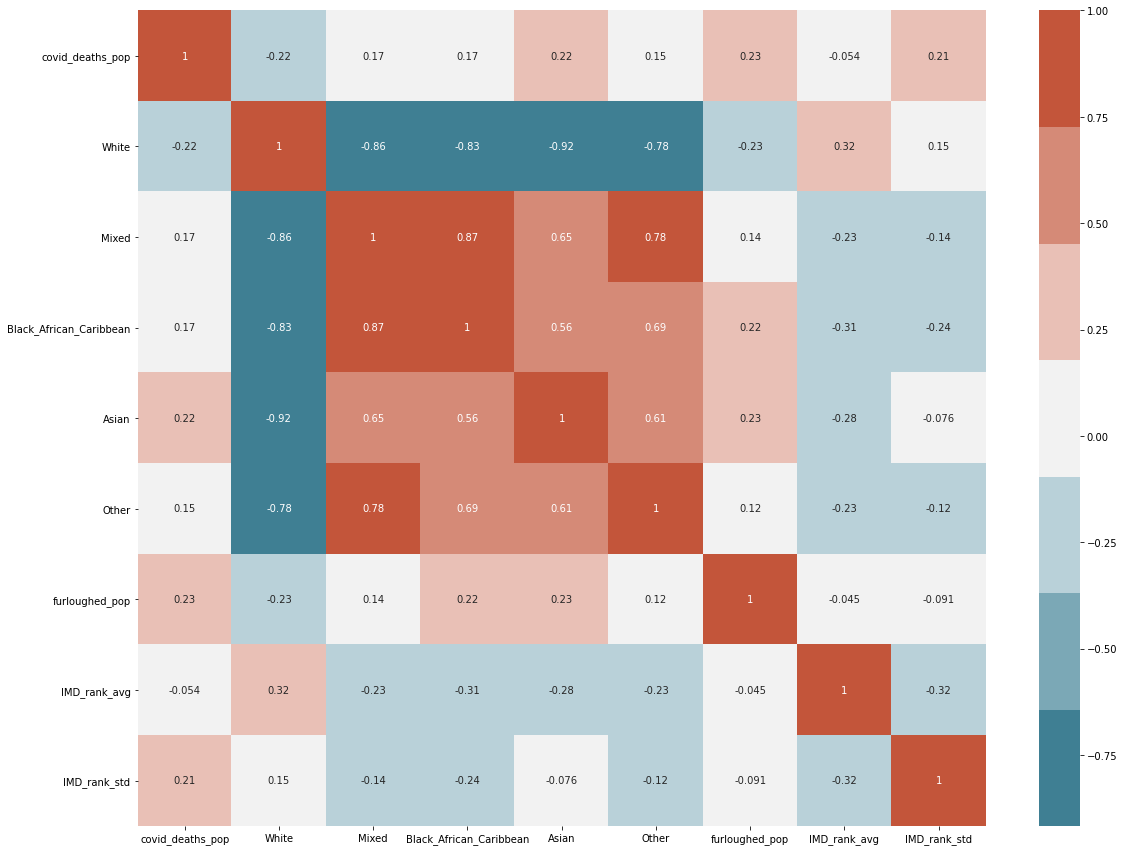

In [34]:
# Adding Furlough
furlough_df = df_grouped.join(bame_datastore.furlough_data.df)
furlough_df["furloughed_pop"] = furlough_df["total_furloughed"]/ furlough_df["total_pop"]
furlough_df = furlough_df.drop(columns=['deaths_all', 'deaths_covid', 'total_pop', 'Area Code', "total_furloughed"])


# Adding Deprivation measures
deprv_df = bame_datastore.deprivation.df.copy()
deprv_df = deprv_df.drop(columns=['IMD_decile_avg', 'IMD_decile_std'])
dep_fur_df = furlough_df.join(deprv_df)
dep_fur_df

plt.figure(figsize=(19, 15))
corrMatrix = dep_fur_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
plt.savefig("../reports/figures/furlough_deprivation_cormat.png")

## Population Density
Calculate population density of local authorities, using the [size of polygons](https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas)
cross refrencing from the [GLA density estimates](https://data.gov.uk/dataset/a76f46f9-c10b-4fe7-82f6-aa928471fcd1/land-area-and-population-density-ward-and-borough) show this calculation is off by a consistent factor of 2.56 

In [21]:
la_gdf = bame_datastore.lad_geog.gdf.copy()
la_gdf = la_gdf.to_crs({'init': 'epsg:3395'}) # change projection to Cartesian 
la_gdf["area"] = la_gdf['geometry'].area/ 10**6 # area in square km
la_gdf.columns

/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Index(['objectid', 'lad09cd', 'lad09nm', 'lad09nmw', 'st_areashape',
       'st_lengthshape', 'geometry', 'area'],
      dtype='object')

In [23]:
furlough_df.columns

Index(['covid_deaths_pop', 'White', 'Mixed', 'Black_African_Caribbean',
       'Asian', 'Other', 'total_furloughed'],
      dtype='object')

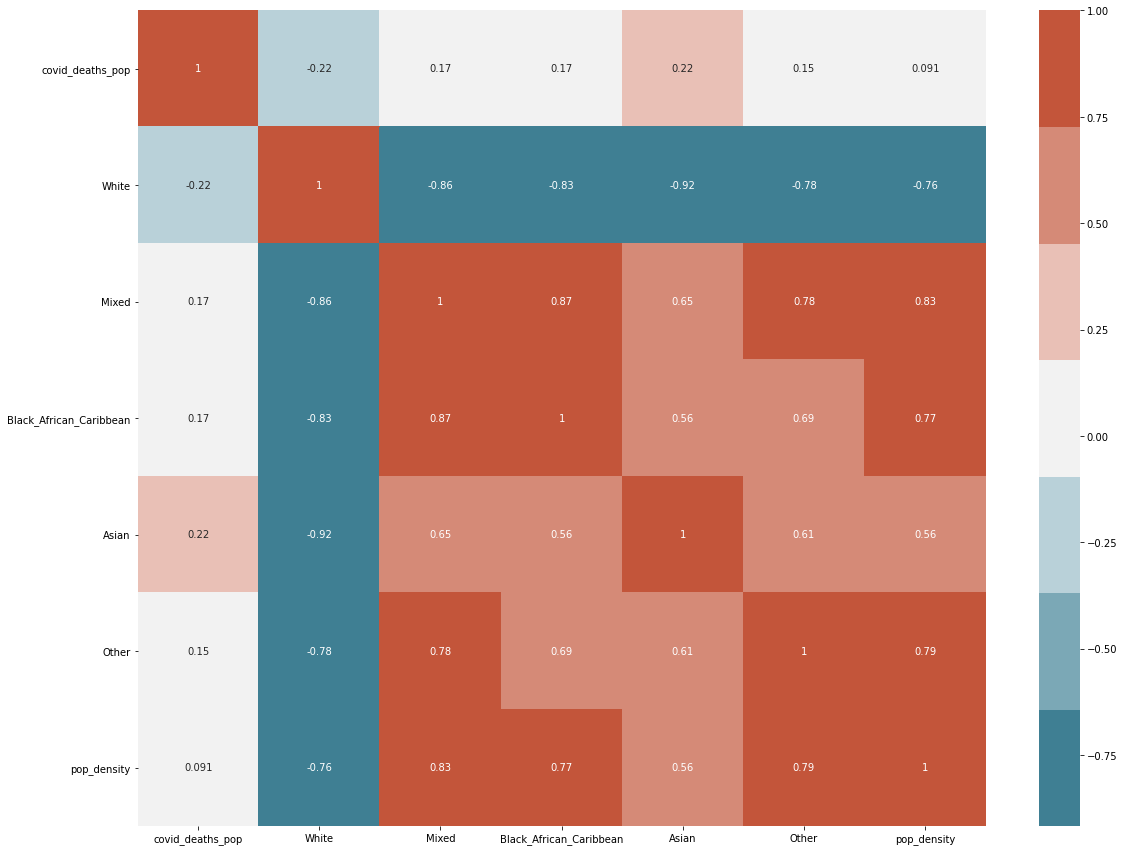

In [24]:
dense_df = df_grouped.join(la_gdf.set_index("lad09nm"))
dense_df["pop_density"] = dense_df["total_pop"]/dense_df["area"]
dense_df = dense_df.drop(columns=["deaths_all", "deaths_covid", "area", "total_pop",
                                  'objectid', 'lad09cd', 'lad09nmw', 'st_areashape','st_lengthshape',])

plt.figure(figsize=(19, 15))
corrMatrix = dense_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))


plt.savefig("../reports/figures/density_corrmat.png")

# Regression
Caution advised

In [ ]:
dense_df
dense_df.to_csv("../data/processed/dense_df.csv")


In [ ]:
reg_all = dense_df.reset_index().drop(columns=["Area Name", "geometry"])
X = reg_all.drop(columns=["covid_deaths_pop"])
y = reg_all.covid_deaths_pop
res = sm.OLS(y, X.astype(float), missing='drop').fit()

res.summary()

